In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms as transforms

!pip install torchmetrics
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics import PeakSignalNoiseRatio as PSNR
!pip install lpips
import lpips

from skimage import color
import torchvision.utils

### Generic Parameter Settings

In [127]:
val_size = 1050
test_size = 2500
use_gpu = True

## Loading ImageNet Data

In [128]:
from torch.utils.data import DataLoader
from torchvision.datasets import STL10


# Define the import_image function to convert images to the desired format
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

# Specify the path to store the dataset
data_path = './data/STL10'

# Download and load the STL-10 dataset
dataset = STL10(root=data_path, transform=img_transform, download=True)

# Create the test dataset
test_dataset = STL10(root=data_path, transform=img_transform, split='test')

dataset = dataset + test_dataset

print("dataset size:", len(dataset))

# Split the dataset into training and validation sets
train_dataset, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_size, val_size])



# Print the sizes of the datasets
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset) )


Files already downloaded and verified
dataset size: 13000
Training dataset size: 9450
Validation dataset size: 1050
Test dataset size: 2500


### Loading CIFAR Data

In [38]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

dataset = CIFAR10('./data/CIFAR10', transform=img_transform, target_transform=None, download=True)
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])
test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)


Files already downloaded and verified
Files already downloaded and verified


### Model

In [108]:
class ColorizationDenseNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationDenseNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        # First half: DenseNet
        densenet = models.densenet121(pretrained=True)
        # Change first conv layer to accept single-channel (grayscale) input
        densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Extract midlevel features from DenseNet-gray
        self.midlevel_densenet = nn.Sequential(*list(densenet.features.children())[0:6])
        
        # Second half: Upsampling
        self.upsample = nn.Sequential(
        nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

    def forward(self, input):

        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_densenet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

In [78]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

### Training

In [65]:
def epoch_loop(dataloader, model, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
    

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    num_batches = 0
    ssim = SSIM().to(device)
    psnr = PSNR().to(device)

    train_loss_avg = [0]
    train_ssim_avg = [0]
    train_psnr_avg = [0]

    with torch.set_grad_enabled(is_train):
      for lab_batch, _ in dataloader:

        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        
        loss = loss_fn(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        if is_train:
          # backpropagation
          optimizer.zero_grad()
          loss.backward()
          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()
        
        # metrics
        train_loss_avg[-1] += loss.item()
        train_ssim_avg[-1] += ssim(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()
        train_psnr_avg[-1] += psnr(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()

        num_batches += 1

    train_loss_avg[-1] /= num_batches
    train_ssim_avg[-1] /= num_batches
    train_psnr_avg[-1] /= num_batches

    return train_loss_avg[-1], train_ssim_avg[-1], train_psnr_avg[-1]

In [48]:
def train_validate(model, loss_fn, num_epochs, optimizer, device, train_dataloader, val_dataloader, model_name):
    best_val_loss = np.inf
    train_history = {'loss': [], 'ssim': [], 'psnr' : []}
    val_history = {'loss': [], 'ssim': [], 'psnr' : []}

    print("Start training...")
    for epoch in range(num_epochs):
      train_loss, train_ssim, train_psnr = epoch_loop(train_dataloader, model, loss_fn, device, optimizer, True)
      print('Train: Epoch [%d / %d] Loss: %f  SSIM: %f PSNR: %f' % (epoch+1, num_epochs, train_loss, train_ssim, train_psnr))
      val_loss, val_ssim, val_psnr = epoch_loop(val_dataloader, model, loss_fn, device, optimizer, False)
      print('Validation: Epoch [%d / %d] Loss: %f  SSIM: %f PSNR: %f' % (epoch+1, num_epochs, val_loss, val_ssim, val_psnr))

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(save_dict, model_name)

      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
      torch.save(save_dict, 'latest_model.pth')

      train_history["loss"].append(train_loss)
      train_history["ssim"].append(train_ssim)
      train_history["psnr"].append(train_psnr)

      val_history["loss"].append(val_loss)
      val_history["ssim"].append(val_ssim)
      val_history["psnr"].append(val_psnr)

    return train_history, val_history

In [49]:
def plotTrainingHistory(train_history, val_history):

    plt.figure(figsize=(10,10))

    plt.subplot(3, 1, 1)
    plt.title('Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(3, 1, 2)
    plt.title('Structural Similarity Index Measure (SSIM)')
    plt.xlabel('Epochs')
    plt.plot(train_history['ssim'], label='train')
    plt.plot(val_history['ssim'], label='val')
    plt.legend(loc='best')

    plt.subplot(3, 1, 3)
    plt.title('Peak Signal-To-Noise Ratio (PSNR)')
    plt.xlabel('Epochs')
    plt.plot(train_history['psnr'], label='train')
    plt.plot(val_history['psnr'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### Evaluate

In [50]:
def evaluate(model, device, loss_fn, optimizer, test_dataloader):
    test_loss, test_ssim, test_psnr = epoch_loop(test_dataloader, model, loss_fn, device, optimizer, False)
    print(f"\nTest Loss: {test_loss:.3f} \nTest SSIM: {test_ssim:.3f} \nTest PSNR: {test_psnr:.3f}")

### Show Results

In [51]:
def show_results(model, device):
    plt.ion()
    with torch.no_grad():

        # pick a random subset of images from the test set
        image_inds = np.random.choice(len(test_dataset), 25, replace=False)
        lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
        lab_batch = lab_batch.to(device)

        # tp = np.transpose(lab_batch[:, 0:1, :, :].numpy(), (2, 0, 1))

        # plt.imshow(tp)
        # plt.show()

        # predict colors (ab channels)
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

        lab_batch = lab_batch.cpu()
        predicted_lab_batch = predicted_lab_batch.cpu()

        # convert to rgb
        rgb_batch = []
        gray_batch = []
        predicted_rgb_batch = []
        for i in range(lab_batch.size(0)):
            rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
            gray_img = np.transpose(lab_batch[i, 0:1, :, :].numpy().astype('float64'), (1, 2, 0))
            gray_batch.append(torch.FloatTensor(np.transpose(gray_img / np.max(gray_img), (2, 0, 1))))
            predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        # plot images
        fig, ax = plt.subplots(figsize=(30, 30), nrows=1, ncols=3)
        ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(gray_batch), nrow=5).numpy(), (1, 2, 0)), cmap='gray')
        ax[0].title.set_text('grayscale')
        ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[1].title.set_text('re-colored')
        ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[2].title.set_text('original')
        plt.show()

## Varying Parameters on ResNet Model

### 1. Varying Loss Function

In [137]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

model = ColorizationNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Number of parameters: 954722


#### 1.1 MSE Loss

In [ ]:
criterion = F.mse_loss

In [139]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'resnet_mse.pth')

Start training...
Train: Epoch [1 / 50] Loss: 161.411016  SSIM: 0.261446 PSNR: 22.010728
Validation: Epoch [1 / 50] Loss: 208.732566  SSIM: 0.212203 PSNR: 20.717123
Train: Epoch [2 / 50] Loss: 153.556540  SSIM: 0.266200 PSNR: 22.253691
Validation: Epoch [2 / 50] Loss: 171.255936  SSIM: 0.216055 PSNR: 21.653100
Train: Epoch [3 / 50] Loss: 150.636898  SSIM: 0.271221 PSNR: 22.307726
Validation: Epoch [3 / 50] Loss: 161.618402  SSIM: 0.271445 PSNR: 21.728955
Train: Epoch [4 / 50] Loss: 147.977376  SSIM: 0.277584 PSNR: 22.419595
Validation: Epoch [4 / 50] Loss: 202.868634  SSIM: 0.200715 PSNR: 20.970016
Train: Epoch [5 / 50] Loss: 146.371522  SSIM: 0.279684 PSNR: 22.453314
Validation: Epoch [5 / 50] Loss: 159.617477  SSIM: 0.273000 PSNR: 21.878738
Train: Epoch [6 / 50] Loss: 145.216307  SSIM: 0.283272 PSNR: 22.464043
Validation: Epoch [6 / 50] Loss: 167.527894  SSIM: 0.241949 PSNR: 21.773737
Train: Epoch [7 / 50] Loss: 144.287533  SSIM: 0.283222 PSNR: 22.516113
Validation: Epoch [7 / 50] Lo

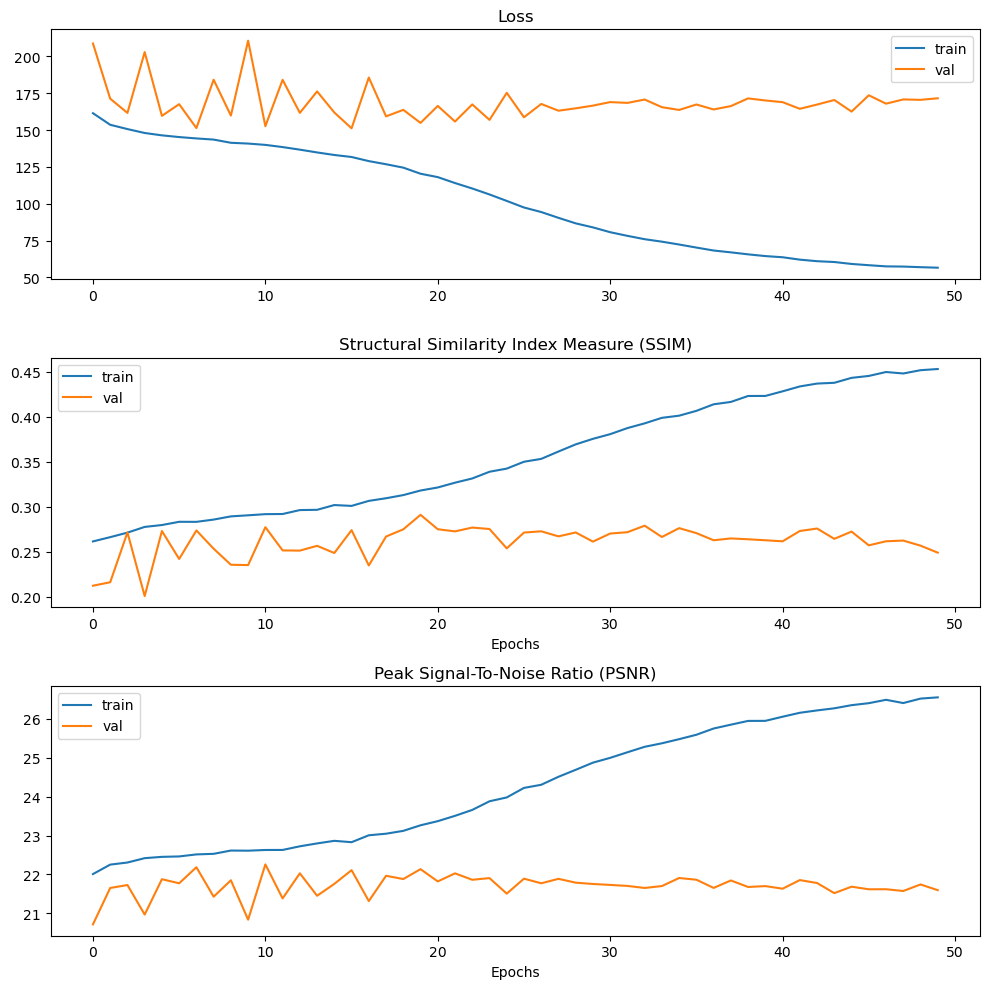

In [140]:
plotTrainingHistory(train_history, val_history)

In [141]:
loaded_model = model.to(device)
checkpoint = torch.load('resnet_mse.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [142]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 152.867 
Test SSIM: 0.279 
Test PSNR: 22.349


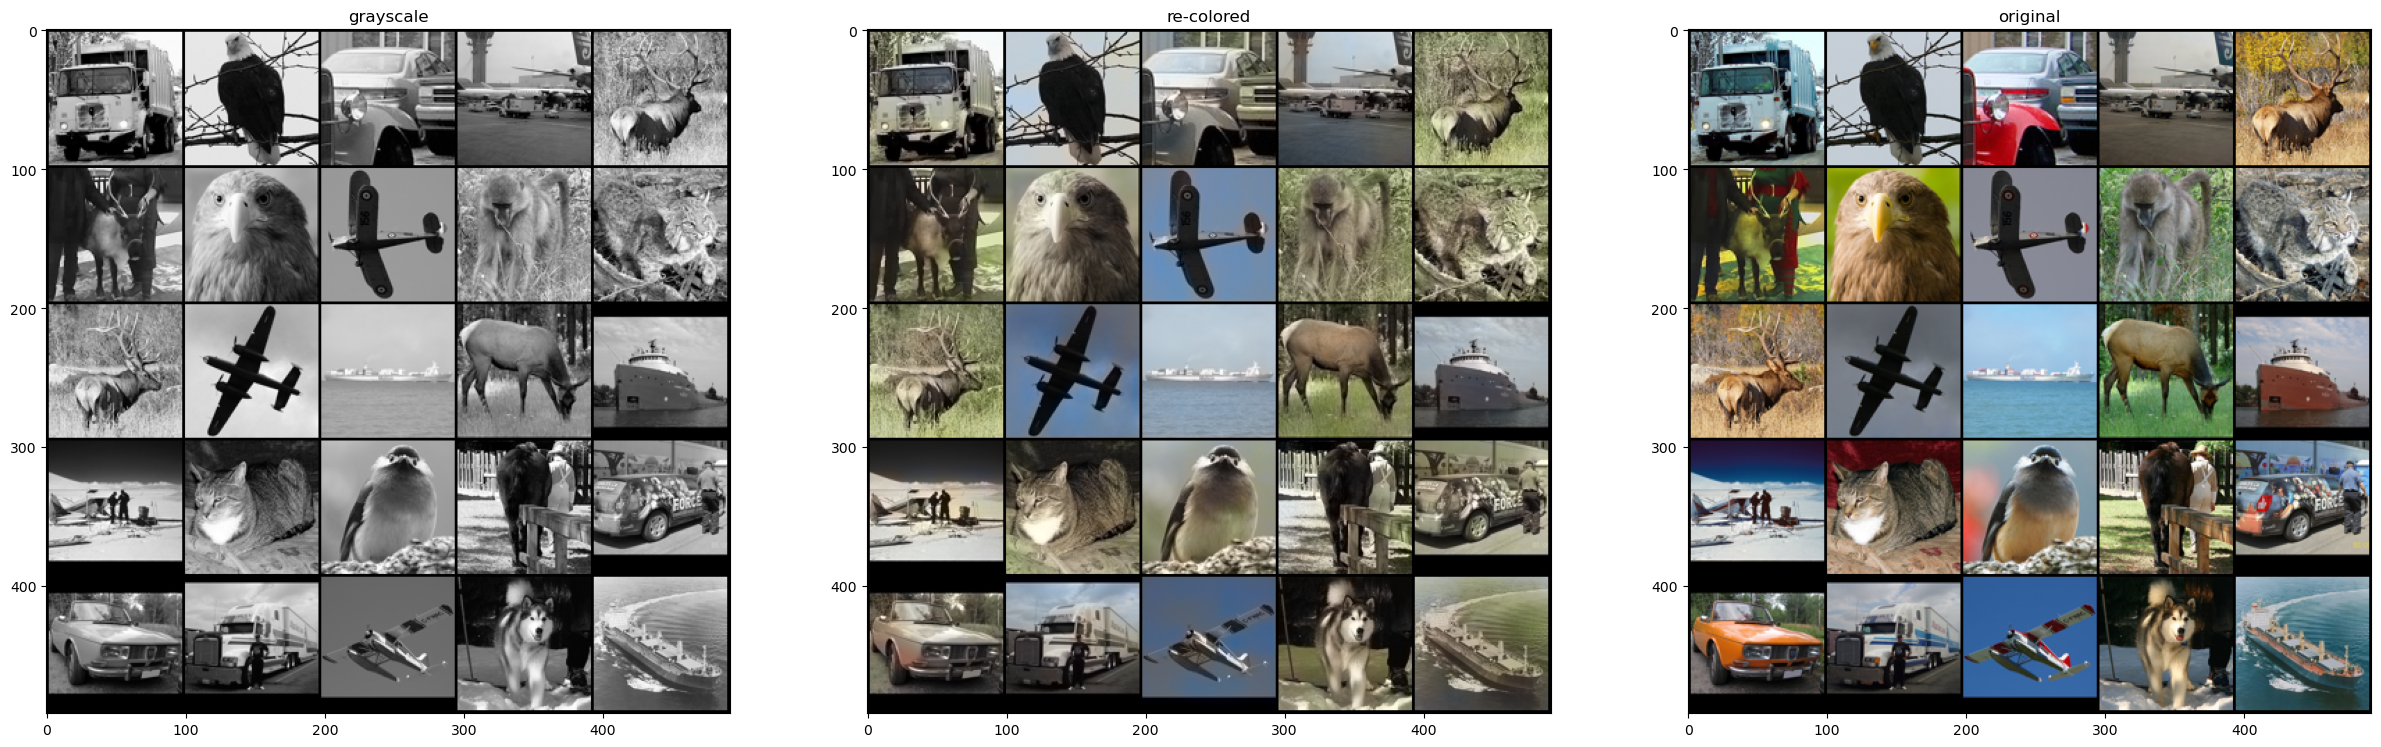

In [143]:
show_results(loaded_model, device)

#### 1.2 LPIPS Loss

In [16]:
criterion = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [17]:
def epoch_loop(dataloader, model, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
    

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    num_batches = 0
    ssim = SSIM().to(device)
    psnr = PSNR().to(device)

    train_loss_avg = [0]
    train_ssim_avg = [0]
    train_psnr_avg = [0]

    with torch.set_grad_enabled(is_train):
      for lab_batch, _ in dataloader:

        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_ab_batch_3 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
        
        # adapated fo lpips
        loss = loss_fn(predicted_ab_batch_3, lab_batch).mean()
        
        if is_train:
          # backpropagation
          optimizer.zero_grad()
          loss.backward()
          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()
        
        # metrics
        train_loss_avg[-1] += loss.item()
        train_ssim_avg[-1] += ssim(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()
        train_psnr_avg[-1] += psnr(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()

        num_batches += 1

    train_loss_avg[-1] /= num_batches
    train_ssim_avg[-1] /= num_batches
    train_psnr_avg[-1] /= num_batches

    return train_loss_avg[-1], train_ssim_avg[-1], train_psnr_avg[-1]

In [18]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'resnet_lpips.pth')

Start training...

Train: Epoch [1 / 50] Loss: 0.103204  SSIM: 0.195422 PSNR: 20.761179

Validation: Epoch [1 / 50] Loss: 0.102903  SSIM: 0.195595 PSNR: 20.797459

Train: Epoch [2 / 50] Loss: 0.099014  SSIM: 0.201666 PSNR: 20.955168

Validation: Epoch [2 / 50] Loss: 0.101244  SSIM: 0.203652 PSNR: 20.947788

Train: Epoch [3 / 50] Loss: 0.097198  SSIM: 0.205644 PSNR: 21.015616

Validation: Epoch [3 / 50] Loss: 0.100544  SSIM: 0.197844 PSNR: 20.869302

Train: Epoch [4 / 50] Loss: 0.095798  SSIM: 0.211226 PSNR: 21.093767

Validation: Epoch [4 / 50] Loss: 0.098098  SSIM: 0.212329 PSNR: 20.958042

Train: Epoch [5 / 50] Loss: 0.094331  SSIM: 0.213270 PSNR: 21.145384

Validation: Epoch [5 / 50] Loss: 0.107491  SSIM: 0.184702 PSNR: 20.569812

Train: Epoch [6 / 50] Loss: 0.092950  SSIM: 0.218910 PSNR: 21.233705

Validation: Epoch [6 / 50] Loss: 0.095269  SSIM: 0.203601 PSNR: 21.110295

Train: Epoch [7 / 50] Loss: 0.091437  SSIM: 0.221503 PSNR: 21.295923

Validation: Epoch [7 / 50] Loss: 0.097953

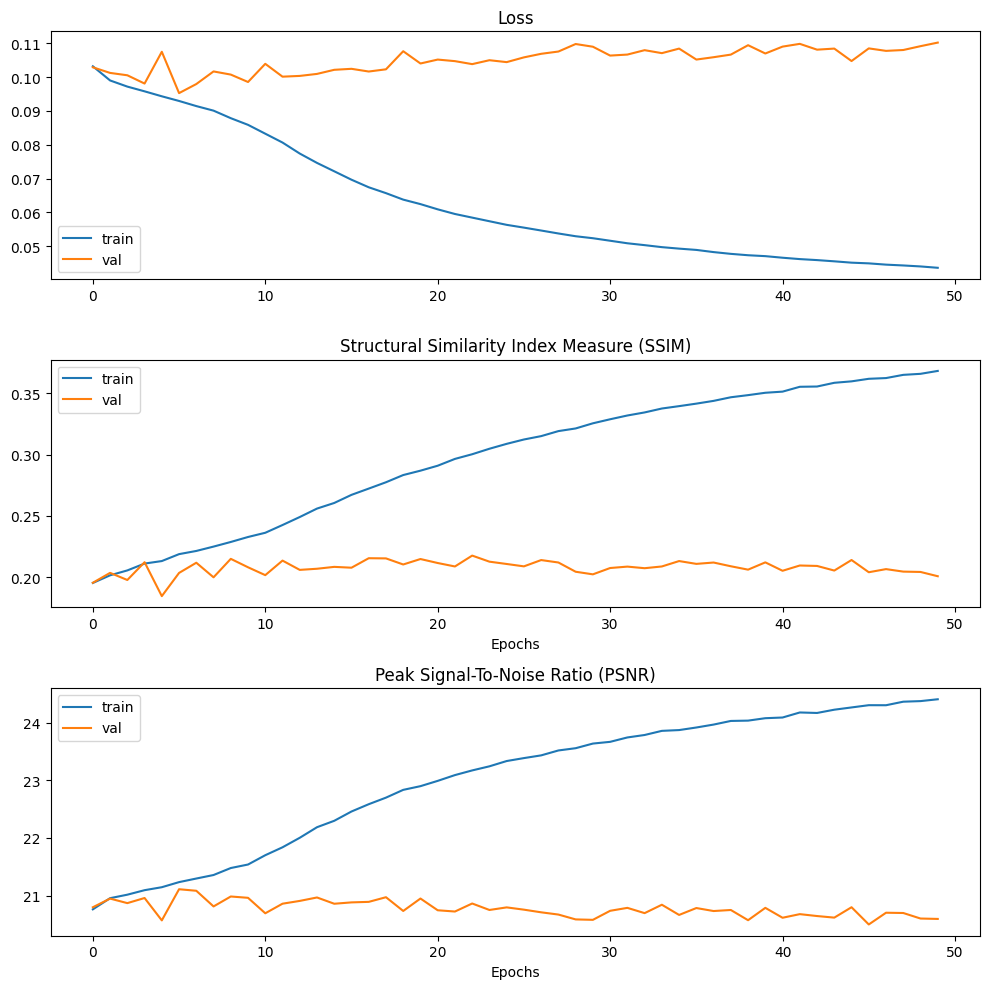

In [19]:
plotTrainingHistory(train_history, val_history)

In [ ]:
loaded_model = model.to(device)
checkpoint = torch.load('resnet_lpips.pth')
loaded_model.load_state_dict(checkpoint['model'])

In [20]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)



Test Loss: 0.095 

Test SSIM: 0.206 

Test PSNR: 21.060


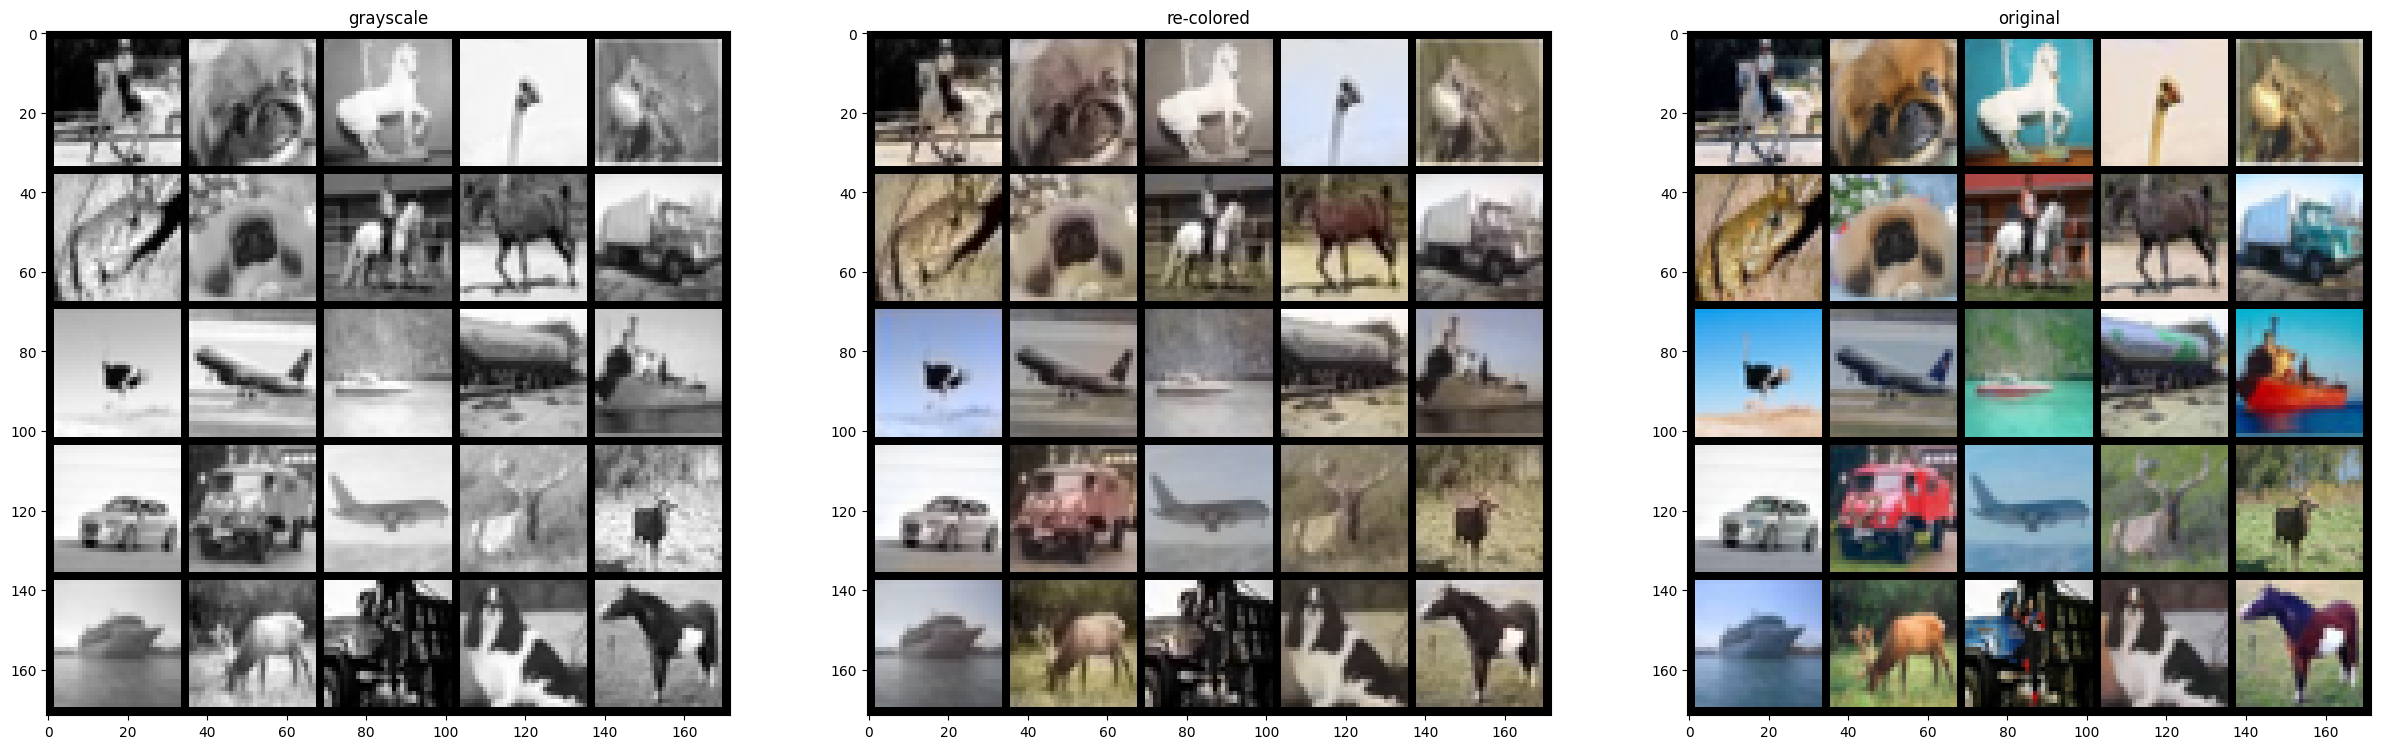

In [21]:
show_results(loaded_model, device)

## DenseNet Model

In [129]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

model = ColorizationDenseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of parameters: 649506


In [131]:
criterion = F.mse_loss

In [132]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'densenet_mse.pth')

Start training...
Train: Epoch [1 / 50] Loss: 158.406263  SSIM: 0.264131 PSNR: 22.089694
Validation: Epoch [1 / 50] Loss: 193.340500  SSIM: 0.244701 PSNR: 21.162801
Train: Epoch [2 / 50] Loss: 149.838879  SSIM: 0.271133 PSNR: 22.350403
Validation: Epoch [2 / 50] Loss: 193.094422  SSIM: 0.247409 PSNR: 21.166826
Train: Epoch [3 / 50] Loss: 148.255380  SSIM: 0.272767 PSNR: 22.362152
Validation: Epoch [3 / 50] Loss: 166.361272  SSIM: 0.271953 PSNR: 21.774876
Train: Epoch [4 / 50] Loss: 146.021637  SSIM: 0.280115 PSNR: 22.428527
Validation: Epoch [4 / 50] Loss: 164.296905  SSIM: 0.251561 PSNR: 21.776196


KeyboardInterrupt: 

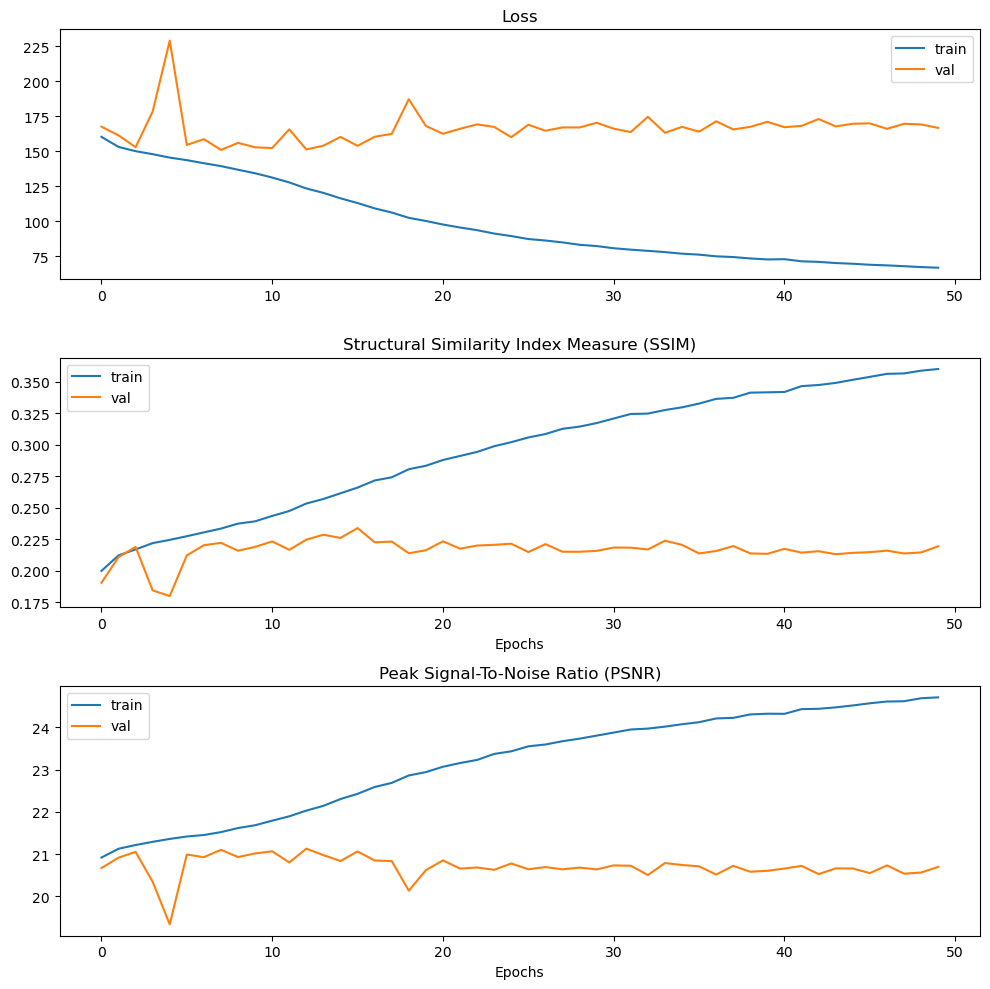

In [111]:
plotTrainingHistory(train_history, val_history)

In [112]:
loaded_model = model.to(device)
checkpoint = torch.load('densenet_mse.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [113]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 149.831 
Test SSIM: 0.225 
Test PSNR: 21.190


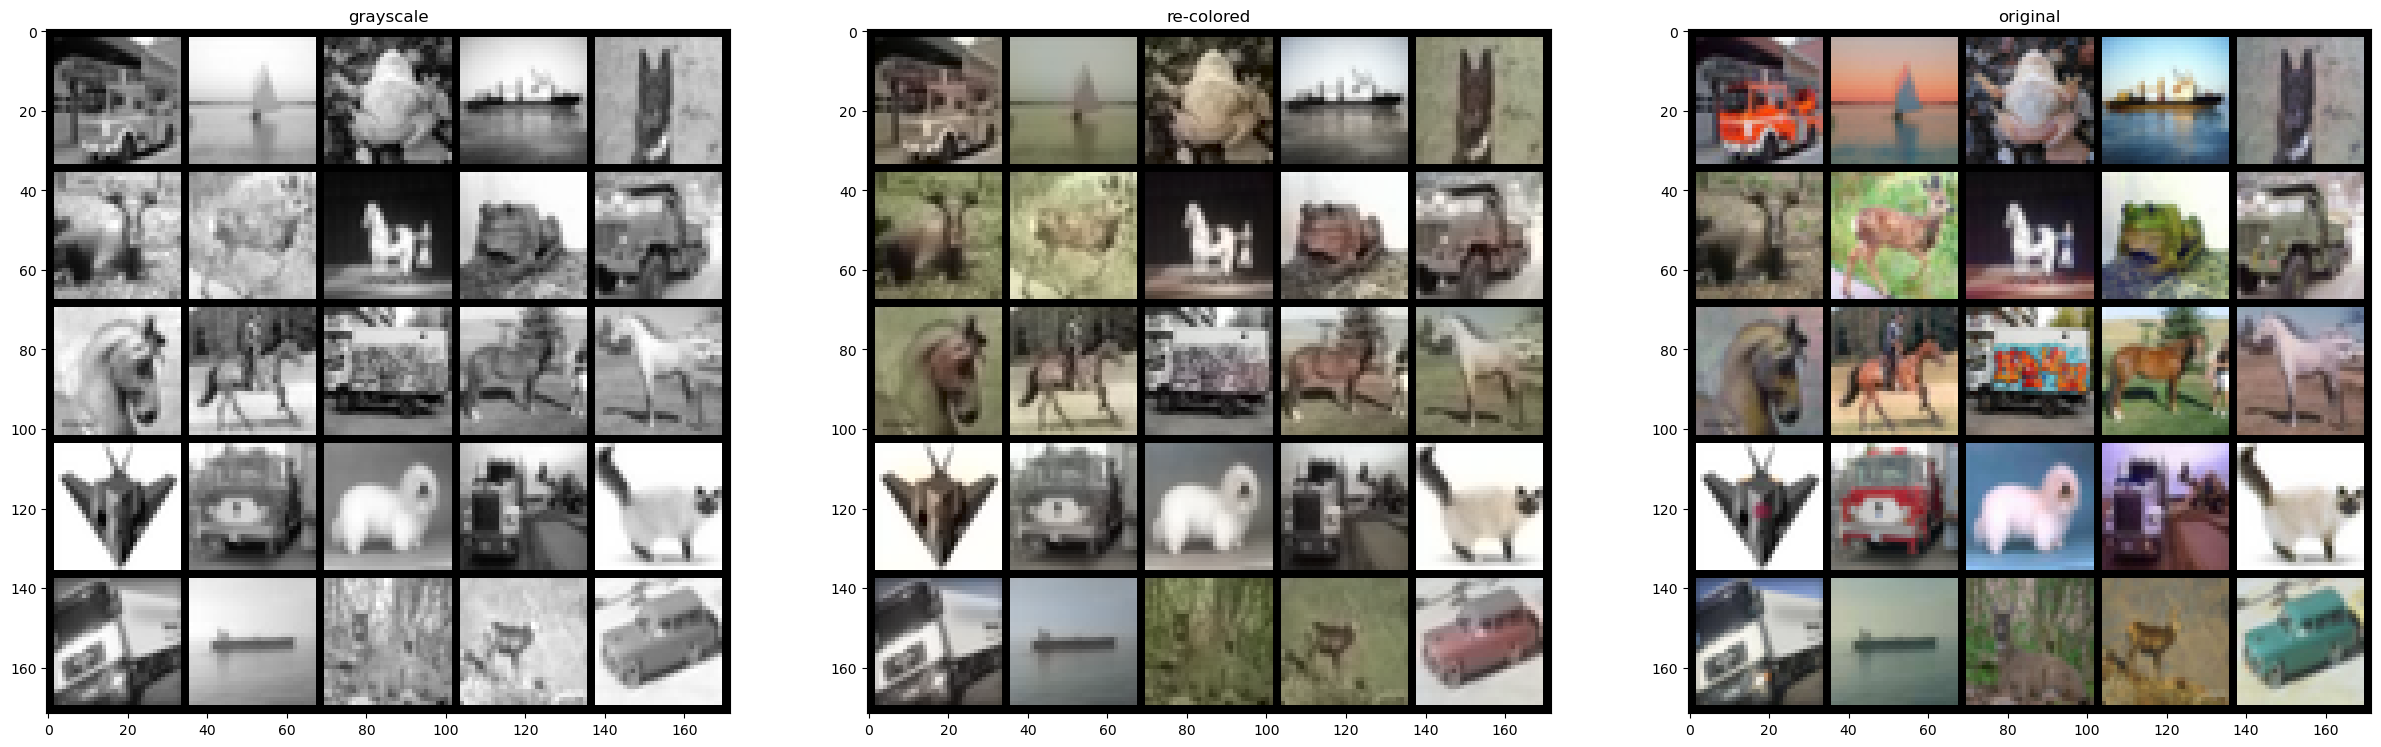

In [114]:
show_results(loaded_model, device)